Базовый эксперимент с RNN, с вариационным выводом

В качестве априоного рассматривается распредедение $\mathcal{N}(\mathbf{0}, 1000\mathbf{I})$,
в качестве вариационного --- $\mathcal{N}(\mathbf{m}, \beta \mathbf{I})$.

In [1]:
import numpy as np
import theano
import theano.tensor as T
import pandas as pd
from sklearn.metrics import f1_score
from collections import OrderedDict
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import seaborn as sns
# sns.set(rc={"figure.figsize": (8, 6.5)})
sns.set(rc={"figure.figsize": (12, 10.8)})
from sklearn.externals import joblib
if theano.config.device == 'gpu':
    from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams
else:
    from theano.tensor.shared_randomstreams import RandomStreams

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GT 740M (CNMeM is disabled, cuDNN not available)


In [2]:
fx = theano.config.floatX
suffix = 'I_I'

plt.style.use('classic')
mpl.rcParams['savefig.format'] = 'pdf'

border = 20

# Подготовка к обучению, создание функций.

Делим выборку в отношении 85%/15%.

In [3]:
X = np.load('semeval_x.npy')
Y= np.load('semeval_y.npy').astype(np.int32)

part = int(len(Y)*0.85)

max_len = max([len(x) for x in X])
X_masked1,X_masked2  = np.zeros((Y.shape[0], max_len, 50)).astype(fx),np.zeros((Y.shape[0], max_len, 50)).astype(fx)
Mask1, Mask2 = np.zeros((Y.shape[0], max_len)).astype(fx), np.zeros((Y.shape[0], max_len)).astype(fx)
for i in range(X.shape[0]//2):
    X_masked1[i, :len(X[2*i])] = X[2*i]
    X_masked2[i, :len(X[2*i+1])] = X[2*i+1]
    Mask1[i,  :len(X[2*i])] = 1.0
    Mask2[i,  :len(X[2*i+1])] = 1.0
    
X_train1, X_test1=X_masked1[:part],  X_masked1[part:],
X_train2, X_test2 = X_masked2[:part],X_masked2[part:]

M_train1, M_test1= Mask1[:part], Mask1[part:],
M_train2, M_test2  = Mask2[:part],Mask2[part:]
Y_train,  Y_test = Y[:part], Y[part:]

Инициализируем переменные:

In [4]:
prior_log_sigma = theano.shared((np.log(10)).astype(fx))
prior_mu = theano.shared(np.array(0.0).astype(fx))
var_log_sigma = theano.shared((np.log(0.1)).astype(fx))

lr = theano.shared(np.array(0.05).astype(fx))
hidden_size = 50
input_size = 50

Создание входных тензоров.

Для каждой группы параметров из модели создаем переменную <название группы>_mean. В терминах Graves - наше вариационное распределение выглядит как:
Q([W_mean, U_mean, b_mean, ...], $e^\text{var_log_sigma}$)

Использовани логарифма в отклонении помогает избежать возможных переполнений и пр.

Все параметры будут храниться в больших shared-тензорах и потом делиться на несколько частей, соответствующих матрицам и векторам. Для упрощения дальнейших записей сразу оговорим размеры матриц и векторов. Для каждого из них будем выделять соответствующий кусок в большом тензоре при помощи различных длин.

In [5]:
shape_W = (input_size,hidden_size)
shape_U = (hidden_size,hidden_size)
shape_b = (hidden_size)
shape_h0 = (hidden_size)
shape_W_softmax = (2*hidden_size,6)
shape_b_softmax = (6)

len_W = shape_W[0]*shape_W[1]; len_W_start = 0
len_U = shape_U[0]*shape_U[1]; len_U_start = len_W_start + len_W
len_b = shape_b; len_b_start = len_U_start + len_U
len_h0 = shape_h0; len_h0_start = len_b_start + len_b
len_W_softmax = shape_W_softmax[0]*shape_W_softmax[1]; len_W_softmax_start = len_h0_start + len_h0
len_b_softmax = shape_b_softmax; len_b_softmax_start = len_W_softmax_start + len_W_softmax

len_flatten = len_W + len_U + len_b + len_h0 + len_W_softmax + len_b_softmax

Суммарное число параметров

In [6]:
len_flatten

5706

Создаём переменную mask_tensor, которая определяет, какие веса будут участвовать в обучении. Также создаём indexes_tensor, хранящий индексы ненулевых элементво mask_tensor.

In [7]:
mask_tensor = theano.shared(np.ones(len_flatten,dtype=fx))
indexes_tensor = mask_tensor.nonzero()[0]

In [8]:
W_mask = mask_tensor[len_W_start:len_W_start+len_W].reshape(shape_W)
U_mask = mask_tensor[len_U_start:len_U_start+len_U].reshape(shape_U)
b_mask = mask_tensor[len_b_start:len_b_start+len_b]
h0_mask = mask_tensor[len_h0_start:len_h0_start+len_h0]
softmax_W_mask = mask_tensor[len_W_softmax_start:len_W_softmax_start+len_W_softmax].reshape(shape_W_softmax)
softmax_b_mask = mask_tensor[len_b_softmax_start:len_b_softmax_start+len_b_softmax]

Аналогично создаём переменную mean_tensor, хранящую средние значения.

In [9]:
mean_tensor = theano.shared(np.zeros(len_flatten,dtype=fx))

In [10]:
W_mean = mean_tensor[len_W_start:len_W_start+len_W].reshape(shape_W)
U_mean = mean_tensor[len_U_start:len_U_start+len_U].reshape(shape_U)
b_mean = mean_tensor[len_b_start:len_b_start+len_b]
h0_mean = mean_tensor[len_h0_start:len_h0_start+len_h0]
softmax_W_mean = mean_tensor[len_W_softmax_start:len_W_softmax_start+len_W_softmax].reshape(shape_W_softmax)
softmax_b_mean = mean_tensor[len_b_softmax_start:len_b_softmax_start+len_b_softmax]

In [11]:
# mask_tensor.set_value(np.ones(len_flatten,dtype=fx))
# mean_tensor.set_value(np.ones(len_flatten,dtype=fx))

В mean_masked_tensor хранятся невырезанные веса. Эта переменная удобна для записи дальнейших формул.

In [12]:
mean_masked_tensor = mean_tensor[indexes_tensor]

Число параметров N_params.

In [13]:
N_params = mean_masked_tensor.shape[0].astype('int32')

In [14]:
N_params.eval()

array(5706, dtype=int32)

In [15]:
X_tensor1, X_tensor2 = T.tensor3(), T.tensor3()
Mask_matrix1, Mask_matrix2 = T.matrix(), T.matrix()
Y_vector = T.ivector()

Сэмплируем параметры.

Теперь все наши параметры имеют на одну размерность больше (размер батча $\times$ старые размерности).
С точки зрения технической реализации, единственное, что нам придется изменить --- это заменить перемножение матриц T.dot на перемножение тензоров T.batched_dot.

Учитываем маски домножением на mask. Обнуление весов в mean будет дальше.

In [16]:
srng = RandomStreams()
W = srng.normal((X_tensor1.shape[0],input_size, hidden_size))*T.exp(var_log_sigma)*W_mask + W_mean
U = srng.normal((X_tensor1.shape[0],hidden_size, hidden_size))*T.exp(var_log_sigma)*U_mask + U_mean
b = srng.normal((X_tensor1.shape[0], hidden_size))*T.exp(var_log_sigma)*b_mask + b_mean
h0 = srng.normal((X_tensor1.shape[0],  hidden_size))*T.exp(var_log_sigma)*h0_mask + h0_mean
softmax_W = srng.normal((X_tensor1.shape[0],2*hidden_size,6))*T.exp(var_log_sigma)*softmax_W_mask +softmax_W_mean
softmax_b = srng.normal((X_tensor1.shape[0],6))*T.exp(var_log_sigma)*softmax_b_mask + softmax_b_mean

Создаём детерминированные батчи для предсказаний:

In [17]:
W_mean_batch = T.zeros((X_tensor1.shape[0],input_size, hidden_size),dtype=fx) + W_mean
U_mean_batch = T.zeros((X_tensor1.shape[0],hidden_size, hidden_size),dtype=fx) + U_mean
b_mean_batch = T.zeros((X_tensor1.shape[0],hidden_size),dtype=fx) + b_mean
h0_mean_batch = T.zeros((X_tensor1.shape[0],hidden_size),dtype=fx) + h0_mean
softmax_W_mean_batch = T.zeros((X_tensor1.shape[0],2*hidden_size,6),dtype=fx) + softmax_W_mean
softmax_b_mean_batch = T.zeros((X_tensor1.shape[0],6),dtype=fx) + softmax_b_mean

Один шаг кодирования:
    $$h_i = \text{tanh}(\mathbf{XW} + \mathbf{h_{i-1}U} + \mathbf{b}) $$
    
XW уже перемножено для оптимизации.

In [18]:
def encode_step(XW_matrix, hidden, U, b):
    return T.tanh(XW_matrix  + T.batched_dot(hidden, U) + b)

Обертка кодирования с учетом маски.

In [19]:
def masked_step(XW, hidden, mask, U, b):
    hid_new = encode_step(XW, hidden, U, b)
    mask_axis = T.tile(mask, (XW.shape[1], 1)).T
    hid_out = T.switch(mask_axis, hid_new, hidden)
    return hid_out

Построение модели.

In [20]:
XW1 = T.batched_dot(X_tensor1, W)
XW2 = T.batched_dot(X_tensor2, W)

hiddens1, hiddens2 = [h0], [h0]
for i in range(max_len):
    hiddens1.append(masked_step(XW1[:,i,:], hiddens1[-1], Mask_matrix1[:,i], U, b))
    hiddens2.append(masked_step(XW2[:,i,:], hiddens2[-1], Mask_matrix2[:,i], U, b))
output = T.nnet.softmax(T.batched_dot(T.concatenate([hiddens1[-1], hiddens2[-1]], axis=1 ), softmax_W)+softmax_b)

In [21]:
softmax_cost = -T.sum(T.log(output)[T.arange(Y_vector.shape[0]), Y_vector])*X_train1.shape[0]/X_tensor1.shape[0]

Аналогично создаём детерминированные версии для предсказания:

In [22]:
XW1_det = T.batched_dot(X_tensor1, W_mean_batch)
XW2_det = T.batched_dot(X_tensor2, W_mean_batch)

hiddens1_det, hiddens2_det = [h0_mean_batch], [h0_mean_batch]
for i in range(max_len):
    hiddens1_det.append(masked_step(XW1_det[:,i,:], hiddens1_det[-1], Mask_matrix1[:,i], U_mean_batch,\
                                        b_mean_batch))
    hiddens2_det.append(masked_step(XW2_det[:,i,:], hiddens2_det[-1], Mask_matrix2[:,i], U_mean_batch,\
                                        b_mean_batch))
output_det = T.nnet.softmax(T.batched_dot(T.concatenate([hiddens1_det[-1], hiddens2_det[-1]], axis=1 ),\
                                          softmax_W_mean_batch)+softmax_b_mean_batch)

Расстояние KL для двух гауссовых распределений.

Смотри русскую вики, в их терминах нулевой индекс соответствует вариационному распределению,
первый индекс - априорному

In [23]:
KLD = N_params * (prior_log_sigma - var_log_sigma) + \
    T.dot(prior_mu- mean_masked_tensor,(prior_mu-mean_masked_tensor).T)/(2*T.exp(2*prior_log_sigma)) + \
    N_params * (T.exp(2*var_log_sigma) - T.exp(2*prior_log_sigma)) /(2*T.exp(2*prior_log_sigma))

In [24]:
cost = softmax_cost + KLD

Код adagrad из lasagne с учётом масок. Производные по выброшенным весам умножаются на ноль.

In [25]:
def lasagne_adagrad_with_mask(loss, params, mask, learning_rate=1.0, epsilon=1e-6):   
    grads = [T.grad(loss,p) for p in params]
    grads[0] = grads[0] * mask_tensor
    updates = OrderedDict()

    for param, grad in zip(params, grads):
        value = param.get_value(borrow=True)
#         value = param.eval() # added by Anton
        accu = theano.shared(np.zeros(value.shape, dtype=value.dtype),
                             broadcastable=param.broadcastable)
        accu_new = accu + grad ** 2
        updates[accu] = accu_new
        updates[param] = param - (learning_rate * grad /
                                  T.sqrt(accu_new + epsilon))

    return updates

Компиляция

In [26]:
evidence_fn = theano.function([X_tensor1, X_tensor2, Mask_matrix1, Mask_matrix2,  Y_vector],cost)

In [27]:
evidence_fn(X_train1,X_train2,M_train1,M_train2,Y_train)

array(36790.499228134155)

In [28]:
params_to_optimize  = [mean_tensor,var_log_sigma]
train_fn = theano.function([X_tensor1, X_tensor2, Mask_matrix1, Mask_matrix2,  Y_vector], cost,  
    updates=lasagne_adagrad_with_mask(cost, params_to_optimize, mask_tensor, learning_rate=lr), 
    on_unused_input='ignore')
predict_fn_det = theano.function([X_tensor1, X_tensor2, Mask_matrix1, Mask_matrix2], output_det, \
    on_unused_input='ignore')

# Обучение

Подготовка к запуску оптимизации. Создаём словарь, который будет хранить самые успешные параметры модели и списки с историями обучения.

In [29]:
best_params = dict()

history_evidence = []
history_score_test = []
history_score_train = []

Создаём специальную функцию для перезапуска обучения. В ней инициализируем матрицы небольшими случайными числами.

In [30]:
def reset_params():
    k = 0.001
    prior_log_sigma.set_value(-2)
    var_log_sigma.set_value(-2)
    prior_mu.set_value(0)
    mean_tensor.set_value((np.random.randn(len_flatten)*k* np.exp(var_log_sigma.eval())).astype(fx))
    best_params.update({'mean_tensor':mean_tensor.get_value()})
    best_params.update({'var_log_sigma':var_log_sigma.get_value()})
    
    history_evidence.clear()
    history_score_test.clear()
    history_score_train.clear()

In [31]:
def reset_masks():
    mask_tensor.set_value(np.ones(len_flatten, dtype=fx))

In [32]:
reset_params()
reset_masks()

Специальная функция для пересчёта априорного распределения.

In [33]:
def update_alpha():
    pls = prior_log_sigma.eval(); vls = var_log_sigma.eval()
    pm = np.array(prior_mu.eval()).reshape(1)[0]; Np = N_params.eval()
    
    prior_mu.set_value(np.mean(mean_masked_tensor.eval()).astype(fx))
    prior_log_sigma.set_value(0.5*np.log((np.exp(2*vls) + np.dot(pm - mean_masked_tensor.eval(),\
         (pm - mean_masked_tensor.eval()).T)/Np).astype(fx)))

Настаиваем параметры запуска модели.

In [34]:
n_epoches = 500
batch_size = 100
esr = 20 # early stopping rounds
lr.set_value(0.01)
average_method = 'weighted'

Валидация считается на всем train и test на каждой эпохе для последующего построения графика. Ранняя остановка делается на основе ошибки на тренировочной выборке.

In [35]:
def train(n_epoches = n_epoches, early_stopping_rounds = 6, batch_size = batch_size, lr_value = None,\
        average_method = 'macro',history_evidence=history_evidence,history_score_test=history_score_test,\
        history_score_train=history_score_train,border=border):
    if lr_value!=None: lr.set_value(lr_value) # чтобы задавать lr извне
    best_score_train = 0; esr_counter = 0; best_epoch = 0; best_score_test = 0 # для ранней остановки
    best_evidence = 1000000000
    for epoch in range(n_epoches):
        batch_results = []
        train_ids = np.arange(X_train1.shape[0])
        np.random.shuffle(train_ids) # рандомизация батчей
        for batch_start in range(0, X_train1.shape[0] + batch_size,  batch_size):
            batch_ids = train_ids[batch_start:min(X_train1.shape[0], batch_start + batch_size)]
            if len(batch_ids)==0: break
            x1, x2 = X_train1[batch_ids], X_train2[batch_ids]
            m1, m2 = M_train1[batch_ids], M_train2[batch_ids]
            y = Y_train[batch_ids]
            batch_results.append(train_fn(x1,x2, m1, m2, y))
            update_alpha()

        evidence = np.mean(batch_results)
        history_evidence.append(evidence)

        print('Epoch =',epoch,'Evidence = ', np.round(evidence,0), '| pls =',np.round(prior_log_sigma.eval(),2),\
              '| vls =', np.round(var_log_sigma.eval(),2),'| mu =', np.round(prior_mu.eval(),5))
        
        y_pred_test = np.argmax(predict_fn_det(X_test1, X_test2, M_test1, M_test2), axis=1)
        y_pred_train = np.argmax(predict_fn_det(X_train1, X_train2, M_train1, M_train2), axis=1)
        score_test = f1_score(Y_test, y_pred_test, average=average_method)
        score_train = f1_score(Y_train, y_pred_train, average=average_method)
        
        history_score_test.append(score_test); history_score_train.append(score_train)
        print('Train_score =',np.round(score_train,3),'| Test_score =',np.round(score_test,3))
        if (evidence < best_evidence - border): esr_counter = 0
        else: esr_counter+=1
        if (evidence < best_evidence): # для ранней остановки
            best_evidence = evidence
            best_score_train = score_train
            best_score_test = score_test
            best_epoch = epoch
            best_params.update({'mean_tensor':mean_tensor.get_value()})
            best_params.update({'var_log_sigma':var_log_sigma.get_value()})
        if (esr_counter >= early_stopping_rounds):
            print('Early Stopping')
            return best_evidence, best_score_train, best_score_test, best_epoch
        elif (epoch==n_epoches-1): return best_evidence, best_score_train, best_score_test, best_epoch

In [37]:
evidence_unprunned, score_unprunned_train, score_unprunned_test, best_unprunned_epoch =\
    train(n_epoches, esr, batch_size, average_method = average_method)

Epoch = 0 Evidence =  13536.0 | pls = -2.13 | vls = -2.15 | mu = -0.00023
Train_score = 0.19 | Test_score = 0.166
Epoch = 1 Evidence =  12700.0 | pls = -2.17 | vls = -2.2 | mu = -0.00034
Train_score = 0.247 | Test_score = 0.228
Epoch = 2 Evidence =  12445.0 | pls = -2.21 | vls = -2.24 | mu = -0.00058


/home/asm/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Train_score = 0.253 | Test_score = 0.241
Epoch = 3 Evidence =  12220.0 | pls = -2.24 | vls = -2.28 | mu = -0.00063
Train_score = 0.262 | Test_score = 0.251
Epoch = 4 Evidence =  12155.0 | pls = -2.26 | vls = -2.3 | mu = -0.00066
Train_score = 0.268 | Test_score = 0.247
Epoch = 5 Evidence =  12038.0 | pls = -2.28 | vls = -2.33 | mu = -0.00059
Train_score = 0.274 | Test_score = 0.257
Epoch = 6 Evidence =  11974.0 | pls = -2.3 | vls = -2.35 | mu = -0.00068
Train_score = 0.284 | Test_score = 0.261
Epoch = 7 Evidence =  11915.0 | pls = -2.32 | vls = -2.37 | mu = -0.0007
Train_score = 0.286 | Test_score = 0.257
Epoch = 8 Evidence =  11802.0 | pls = -2.34 | vls = -2.38 | mu = -0.00072
Train_score = 0.289 | Test_score = 0.265
Epoch = 9 Evidence =  11783.0 | pls = -2.35 | vls = -2.4 | mu = -0.00071
Train_score = 0.287 | Test_score = 0.256
Epoch = 10 Evidence =  11768.0 | pls = -2.36 | vls = -2.41 | mu = -0.00074
Train_score = 0.295 | Test_score = 0.28
Epoch = 11 Evidence =  11768.0 | pls = -2.3

In [ ]:
# score_unprunned, tmp = train(n_epoches, esr, batch_size, average_method = average_method)

Функции сохранения и загрузки весов пригодятся при прунинге

In [37]:
def save_weights():
    np.save('Weights/mean_tensor_'+suffix+'.npy',best_params['mean_tensor'])
    np.save('Weights/var_log_sigma_'+suffix+'.npy',best_params['var_log_sigma'])

In [38]:
def load_weights():
    mean_tensor.set_value(np.load('Weights/mean_tensor_'+suffix+'.npy'))
    var_log_sigma.set_value(np.load('Weights/var_log_sigma_'+suffix+'.npy'))
    mask_tensor.set_value(np.ones(len_flatten, dtype=fx))
    update_alpha()

In [40]:
from sklearn.externals import joblib
joblib.dump(history_evidence,'Weights/history_evidence_'+suffix)

['Weights/history_evidence_I_I']

Сохраняем значения весов:

In [41]:
save_weights()

# Анализ результатов обучения

Графики обучения до прунинга

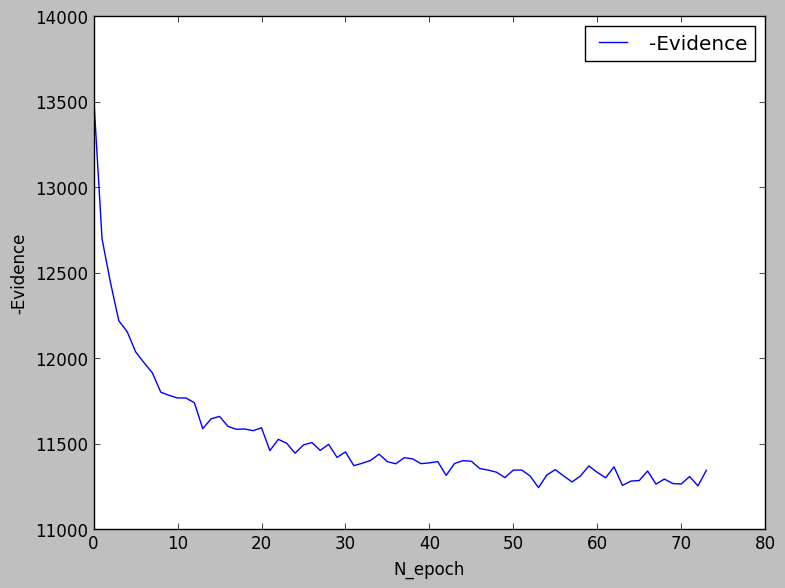

In [85]:
plt.plot(history_evidence)
plt.legend(['-Evidence'])
plt.xlabel('N_epoch')
plt.ylabel('-Evidence')
plt.savefig('Pictures/Evidence_unprunned_'+suffix)
plt.tight_layout()

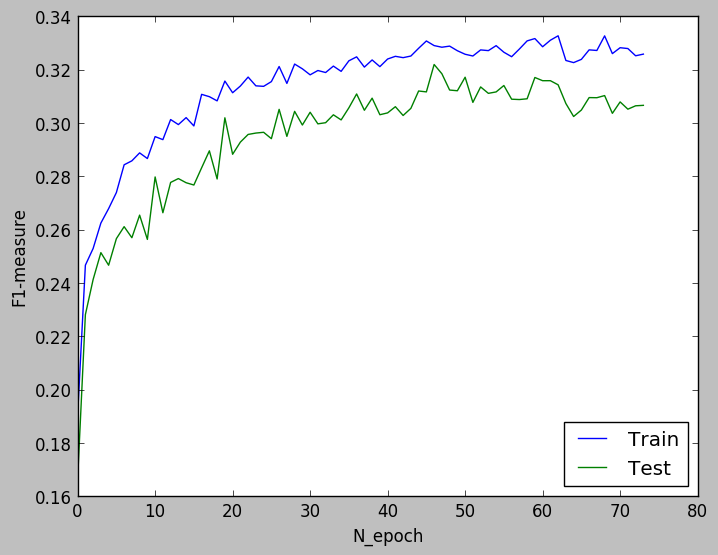

In [80]:
plt.plot(history_score_train)
plt.plot(history_score_test)
plt.legend(['Train','Test'],loc='lower right')
plt.xlabel('N_epoch')
plt.ylabel('F1-measure')
plt.savefig('Pictures/Train_test_score_unprunned_'+suffix)

Загружаем значения весов:

In [200]:
load_weights()

RuntimeError: ("Cuda error 'unspecified launch failure' while copying 5706 data element to device memory. str ptr=0x149d3420. dst ptr=0x5023d6800", 'Container name "None"')

Подсчитываем значение bits для каждого веса матрицы W и U:

In [40]:
bits_W = T.switch(W_mask,(prior_log_sigma - var_log_sigma) + ((W_mean-prior_mu)**2 + np.exp(2*var_log_sigma)\
                              - np.exp(2*prior_log_sigma))/(2*np.exp(2*prior_log_sigma)),0)
bits_U = T.switch(U_mask,(prior_log_sigma - var_log_sigma) + ((U_mean-prior_mu)**2 + np.exp(2*var_log_sigma)\
                              - np.exp(2*prior_log_sigma))/(2*np.exp(2*prior_log_sigma)),0)

Вычисляем Bits/weight для полной сети:

In [41]:
bit_per_weight_unprunned = (KLD/N_params).eval()
bit_per_weight_unprunned

array(0.0813770663371188)

Визуалицируем значения bits для матриц W и U с помощью тепловых карт.

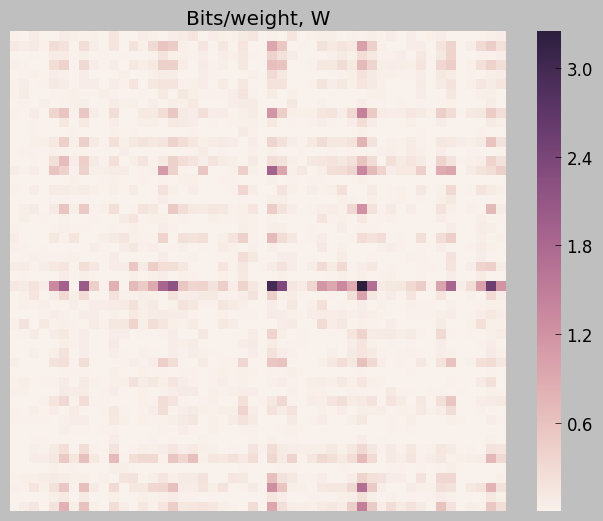

In [100]:
ax = sns.heatmap(bits_W.eval())
ax.axes.get_xaxis().set_visible(False); ax.axes.get_yaxis().set_visible(False)
plt.title('Bits/weight, W')
plt.savefig('Pictures/bits_W_unprunned_'+suffix)

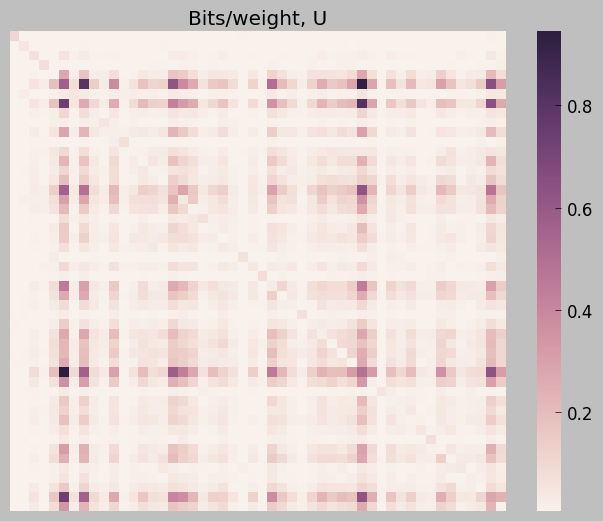

In [101]:
ax = sns.heatmap(bits_U.eval())
ax.axes.get_xaxis().set_visible(False); ax.axes.get_yaxis().set_visible(False)
plt.title('Bits/weight, U')
plt.savefig('Pictures/bits_U_unprunned_'+suffix)

Смотрим на распределение самих весов.

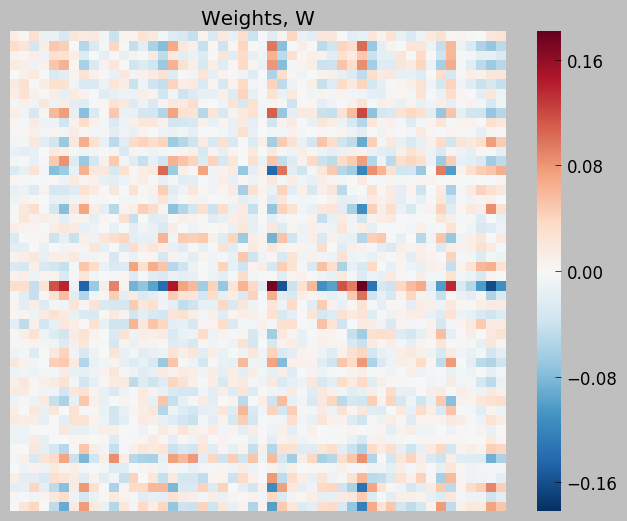

In [102]:
ax = sns.heatmap(W_mean.eval())
ax.axes.get_xaxis().set_visible(False); ax.axes.get_yaxis().set_visible(False)
plt.title('Weights, W')
plt.savefig('Pictures/W_matrix_unprunned_'+suffix)

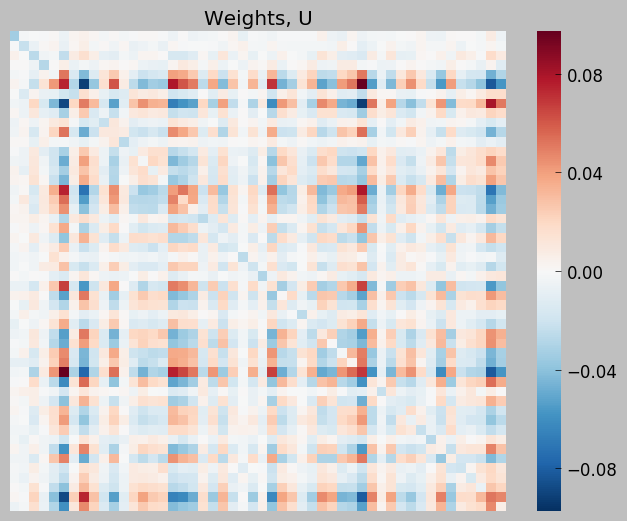

In [103]:
ax = sns.heatmap(U_mean.eval())
ax.axes.get_xaxis().set_visible(False); ax.axes.get_yaxis().set_visible(False)
plt.title('Weights, U')
plt.savefig('Pictures/U_matrix_unprunned_'+suffix)

# Прунинг.

Функция, которая по W_mean и var_log_sigma возвращает маску весов.

In [42]:
def pruning_mask(mean_tensor, ld, var_log_sigma):
    mask = T.abs_(mean_tensor/T.exp(var_log_sigma)).eval() >= ld
    return mask

Запоминаем исходное число параметров.

In [43]:
N_params_unprunned = N_params.eval()

График зависимости доли оставшихся весов в зависимости от параметра $\lambda$.

In [199]:
x_range = np.linspace(0,1.5,100)
y = [pruning_mask(mean_tensor,ld,var_log_sigma).sum()/N_params.eval() for ld in x_range]
plt.plot(x_range,y)
plt.xlabel('$\lambda$')
plt.ylabel('Proportion of weights')
plt.title('Scalar variance')
plt.savefig('Pictures/Portion_of_pruned_weights_on_lambda_'+suffix+'.pdf')

RuntimeError: error (unspecified launch failure)copying data to host
Apply node that caused the error: HostFromGpu(GpuElemwise{Composite{Abs((i0 / i1))},no_inplace}.0)
Toposort index: 4
Inputs types: [CudaNdarrayType(float32, vector)]
Inputs shapes: [(5706,)]
Inputs strides: [(1,)]
Inputs values: ['not shown']
Outputs clients: [['output']]

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

In [115]:
joblib.dump(y,'History/lambda_'+suffix)

['History/lambda_I_I']

In [46]:
z1 = joblib.load('History/lambda_I_I')
z2 = joblib.load('History/lambda_D_I')

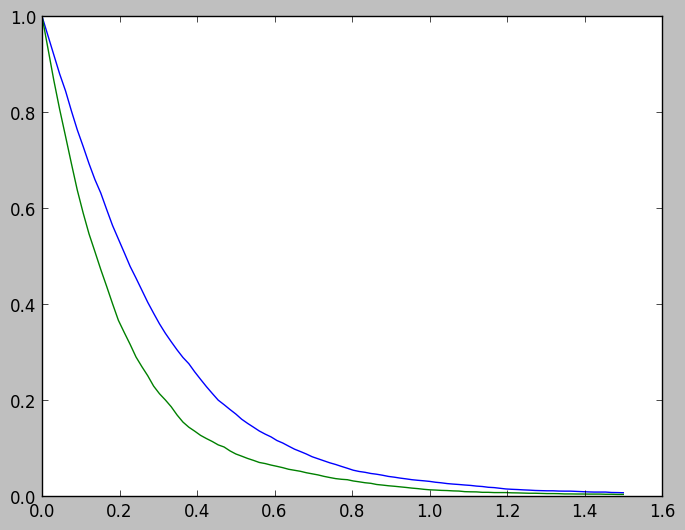

In [47]:
plt.plot(x_range,z1)
plt.plot(x_range,z2)

Список различных вариантов для прунинга.

In [120]:
# ld_list = np.linspace(0.1,1.2,12)

In [48]:
ld_list = [0.05,0.1,0.2,0.4,0.6,0.8,1,1.2,1.4]

Сначала заполняем данные для полной сети.

In [49]:
unprunned_result = pd.Series(name='unprunned')
unprunned_result['Lambda'] = 0
unprunned_result['Weights_number'] = N_params_unprunned
unprunned_result['Portion_of_weights'] = 1
# unprunned_result['Initial_score'] = score_unprunned_test # 0.311083
# unprunned_result['Retrain_score'] = score_unprunned_test # 0.311083
unprunned_result['Initial_score'] = 0.311083
unprunned_result['Retrain_score'] = 0.311083
unprunned_result['Retrain_epochs'] = 0
unprunned_result['Bits/weight'] = bit_per_weight_unprunned
# unprunned_result['Initial_evidence'] = evidence_unprunned
# unprunned_result['Retrain_evidence'] = evidence_unprunned
unprunned_result['Initial_evidence'] = 11243.4
unprunned_result['Retrain_evidence'] = 11243.4

# Дообучение

Параметры дообучения. Создаём таблицу result_df, в которую записываются результаты. Создаём словари, которые будут хранить историю обучения.

In [50]:
n_epoches = 200
esr = 20
batch_size = 100
lr.set_value(0.01)
history_evidence_ld = dict()
history_score_test_ld = dict()
history_score_train_ld = dict()
params_ld = dict()
n_iter = 2

result_df = pd.DataFrame()
result_df = result_df.append(unprunned_result)

average_method = 'weighted'

In [51]:
result_df[['Lambda','Weights_number','Portion_of_weights','Initial_evidence','Retrain_evidence','Initial_score',\
           'Retrain_score','Retrain_epochs','Bits/weight']]

,Lambda,Weights_number,Portion_of_weights,Initial_evidence,Retrain_evidence,Initial_score,Retrain_score,Retrain_epochs,Bits/weight
unprunned,0.0,5706,1.0,11243.4,11243.4,0.311083,0.311083,0.0,0.0813770663371188


Дообучаем сеть для каждого lambda, запоминаем всю историю.

In [65]:
# def pruning_retrain(ld_list,result_df):
for ld_n, ld in enumerate(ld_list[:]):
    history_evidence_tmp = []; history_score_train = []; history_score_test = []
    name = 'ld_'+str(ld)
    load_weights()

    mask_new = pruning_mask(mean_tensor,ld,var_log_sigma)
    mask_tensor.set_value(mask_new.astype('float32'))
    
    new_mean = mean_tensor.get_value()
    new_mean[~mask_new] = 0
    mean_tensor.set_value(new_mean.astype(fx))
    
    print('N_params =', N_params.eval())

    initial_predict = np.argmax(predict_fn_det(X_test1, X_test2, M_test1, M_test2), axis=1)
    initial_score = f1_score(Y_test, initial_predict, average=average_method)
    print('initial_score =',initial_score)
    initial_evidence = evidence_fn(X_train1,X_train2,M_train1,M_train2,Y_train)
    retrain_evidence, retrain_score_train, retrain_score_test, retrain_epochs = train(n_epoches, esr,\
        batch_size,average_method=average_method,history_evidence=history_evidence_tmp,\
        history_score_train=history_score_train,history_score_test=history_score_test,border=border)

    bits_per_weigth = (KLD/N_params).eval() # вычисляем Bits/Weight

    result = pd.Series(name=name) # Систематизируем полученные данные
    result['Lambda'] = ld
    result['Weights_number'] = N_params.eval()
    result['Portion_of_weights'] = N_params.eval()/N_params_unprunned
    result['Initial_evidence'] = initial_evidence
    result['Retrain_evidence'] = retrain_evidence
    result['Initial_score'] = initial_score
    result['Retrain_score'] = retrain_score_test
    result['Retrain_epochs'] = retrain_epochs
    result['Bits/weight'] = bits_per_weigth
    result_df = result_df.append(result) # добавляем данные в таблицу

    print('bits_per_weigth =',bits_per_weigth)

    history_evidence_ld.update({name:history_evidence_tmp}); history_score_test_ld.update({name:history_score_test})
    history_score_train_ld.update({name:history_score_train}) # обновляем историю
#     return result_df

N_params = 4959


/home/asm/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


initial_score = 0.312359283848
Epoch = 0 Evidence =  11251.0 | pls = -2.63 | vls = -2.72 | mu = -0.0013
Train_score = 0.331 | Test_score = 0.32
Epoch = 1 Evidence =  11162.0 | pls = -2.63 | vls = -2.73 | mu = -0.00131
Train_score = 0.331 | Test_score = 0.318
Epoch = 2 Evidence =  11261.0 | pls = -2.64 | vls = -2.73 | mu = -0.00132
Train_score = 0.329 | Test_score = 0.312
Epoch = 3 Evidence =  11272.0 | pls = -2.64 | vls = -2.74 | mu = -0.00132
Train_score = 0.329 | Test_score = 0.311
Epoch = 4 Evidence =  11273.0 | pls = -2.65 | vls = -2.75 | mu = -0.00133
Train_score = 0.332 | Test_score = 0.314
Epoch = 5 Evidence =  11197.0 | pls = -2.65 | vls = -2.75 | mu = -0.00135
Train_score = 0.33 | Test_score = 0.311
Epoch = 6 Evidence =  11215.0 | pls = -2.66 | vls = -2.75 | mu = -0.00136
Train_score = 0.33 | Test_score = 0.31
Epoch = 7 Evidence =  11237.0 | pls = -2.66 | vls = -2.76 | mu = -0.00138
Train_score = 0.328 | Test_score = 0.31
Epoch = 8 Evidence =  11202.0 | pls = -2.66 | vls = -2.

Результаты в одной таблице:

In [70]:
n_iter = 2

In [74]:
# result_df = result_df.iloc[10:,:]

In [87]:
result_df = result_df.append(unprunned_result)

In [86]:
result_df.append(unprunned_result)

,Bits/weight,Initial_evidence,Initial_score,Lambda,Portion_of_weights,Retrain_epochs,Retrain_evidence,Retrain_score,Weights_number
ld_0.05,0.10426310812710839,11247.10885508668,0.312359,0.05,0.869085,17.0,11153.477486,0.309475,4959
ld_0.1,0.11898946492159838,11198.142581174312,0.316386,0.10,0.741851,19.0,11081.716598,0.313610,4233
ld_0.2,0.15672895949851953,11117.204180739112,0.311441,0.20,0.529267,31.0,10989.129224,0.301260,3020
ld_0.4,0.2611439228841225,11190.85201303608,0.299815,0.40,0.252015,29.0,10757.050763,0.302638,1438
ld_0.6,0.4534619466277983,11628.73157463511,0.301383,0.60,0.120049,48.0,10662.448637,0.297071,685
ld_0.8,0.7675926144827907,11947.62487665054,0.259550,0.80,0.055030,68.0,10725.089122,0.288001,314
ld_1,0.9991187176092182,12096.577760435905,0.263091,1.00,0.031370,83.0,10857.717457,0.287336,179
ld_1.2,1.1134207495257689,12199.959316229493,0.218471,1.20,0.015422,53.0,11501.228703,0.211079,88
ld_1.4,1.2291688102281926,12267.682885162687,0.217990,1.40,0.009639,54.0,11625.466979,0.195832,55
unprunned,0.0813770663371188,11243.4,0.311083,0.00,1.000000,0.0,11243.400000,0.311083,5706


In [104]:
result_df[['Lambda','Weights_number','Portion_of_weights','Initial_evidence','Retrain_evidence','Initial_score',
           'Retrain_score','Retrain_epochs','Bits/weight']]

,Lambda,Weights_number,Portion_of_weights,Initial_evidence,Retrain_evidence,Initial_score,Retrain_score,Retrain_epochs,Bits/weight
unprunned,0.00,5706,1.000000,11243.4,11243.400000,0.311083,0.311083,0.0,0.0813770663371188
ld_0.05,0.05,4959,0.869085,11247.10885508668,11153.477486,0.312359,0.309475,17.0,0.10426310812710839
ld_0.1,0.10,4233,0.741851,11198.142581174312,11081.716598,0.316386,0.313610,19.0,0.11898946492159838
ld_0.2,0.20,3020,0.529267,11117.204180739112,10989.129224,0.311441,0.301260,31.0,0.15672895949851953
ld_0.4,0.40,1438,0.252015,11190.85201303608,10757.050763,0.299815,0.302638,29.0,0.2611439228841225
ld_0.6,0.60,685,0.120049,11628.73157463511,10662.448637,0.301383,0.297071,48.0,0.4534619466277983
ld_0.8,0.80,314,0.055030,11947.62487665054,10725.089122,0.259550,0.288001,68.0,0.7675926144827907
ld_1,1.00,179,0.031370,12096.577760435905,10857.717457,0.263091,0.287336,83.0,0.9991187176092182
ld_1.2,1.20,88,0.015422,12199.959316229493,11501.228703,0.218471,0.211079,53.0,1.1134207495257689
ld_1.4,1.40,55,0.009639,12267.682885162687,11625.466979,0.217990,0.195832,54.0,1.2291688102281926


In [99]:
r = pd.DataFrame([unprunned_result],columns=unprunned_result.index)
t = pd.concat([r, result_df],axis=0)

In [102]:
result_df_copy = result_df

In [103]:
result_df = t.iloc[:-1,:]

In [ ]:
# import matplotlib as mpl
# plt.style.use('seaborn-paper')
# mpl.rcParams['lines.linewidth'] = 2
# mpl.rcParams['figure.figsize'] = (12, 10.8)
# # mpl.rcParams['axes.titlesize'] = 24
# # mpl.rcParams['axes.labelsize'] = 24
# mpl.rcParams['xtick.labelsize'] = 15
# mpl.rcParams['ytick.labelsize'] = 15
# mpl.rcParams['legend.fontsize'] = 18
# # mpl.rcParams['savefig.transparent'] = False
# mpl.rcParams['savefig.format'] = 'eps'
# # mpl.rcParams['savefig.facecolor'] = 'White'
# # mpl.rcParams['lines.markersize'] = 6
# # mpl.rcParams['legend.fontsize'] = 24
# # mpl.rcParams['legend.fontsize'] = 24
# # mpl.rcParams['legend.fontsize'] = 24

Смотрим, как изменилась ошибка:

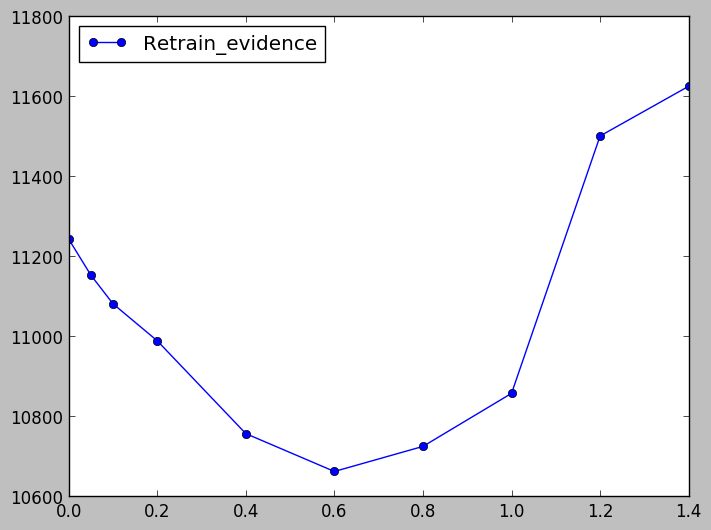

In [105]:
fig, ax = plt.subplots()
line_1, = ax.plot(result_df.loc[:,'Lambda'].values,result_df.loc[:,'Retrain_evidence'].values, marker='o')
ax.legend(['Retrain_evidence'],loc='upper left')
plt.savefig('Pictures/evidence_lambda_'+suffix)

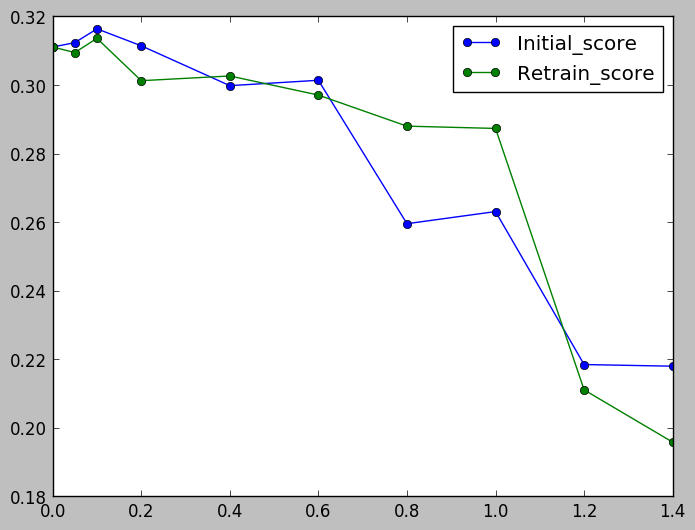

In [106]:
fig, ax = plt.subplots()
line_1, = ax.plot(result_df.loc[:,'Lambda'].values,result_df.loc[:,'Initial_score'].values, marker='o')
line_2, = ax.plot(result_df.loc[:,'Lambda'].values,result_df.loc[:,'Retrain_score'].values, marker='o')
ax.legend(['Initial_score','Retrain_score'])
plt.savefig('Pictures/lambda_'+suffix)

score(доля оставшихся весов)

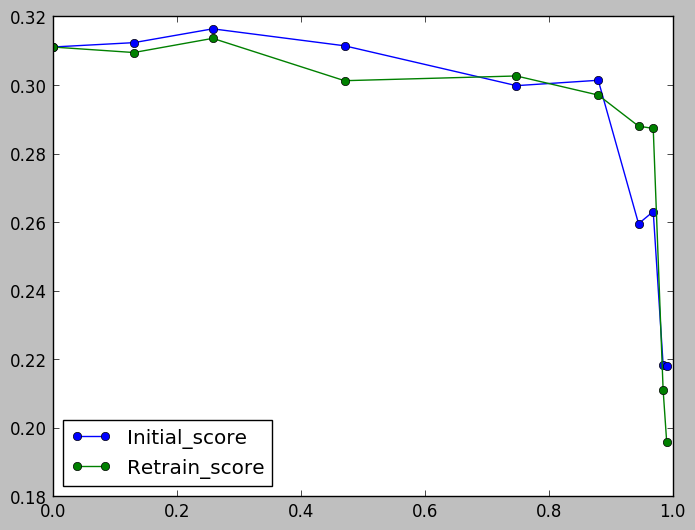

In [107]:
fig, ax = plt.subplots()
line_1, = ax.plot(1-result_df.loc[:,'Portion_of_weights'].values,result_df.loc[:,'Initial_score'].values,marker='o')
line_2, = ax.plot(1-result_df.loc[:,'Portion_of_weights'].values,result_df.loc[:,'Retrain_score'].values,marker='o')
ax.legend(['Initial_score','Retrain_score'],loc='lower left')
plt.savefig('Pictures/portion_'+suffix)

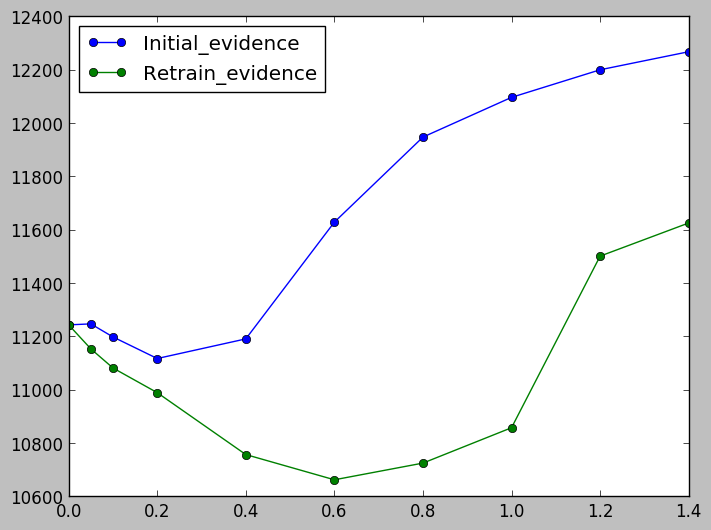

In [108]:
fig, ax = plt.subplots()
line_1, = ax.plot(result_df.loc[:,'Lambda'].values,result_df.loc[:,'Initial_evidence'].values, marker='o')
line_2, = ax.plot(result_df.loc[:,'Lambda'].values,result_df.loc[:,'Retrain_evidence'].values, marker='o')
ax.legend(['Initial_evidence','Retrain_evidence'],loc='upper left')
plt.savefig('Pictures/pruning_evidence_'+suffix)

Графики дообучения

Итоговая таблица:

In [109]:
result_df

,Bits/weight,Initial_evidence,Initial_score,Lambda,Portion_of_weights,Retrain_epochs,Retrain_evidence,Retrain_score,Weights_number
unprunned,0.0813770663371188,11243.4,0.311083,0.00,1.000000,0.0,11243.400000,0.311083,5706
ld_0.05,0.10426310812710839,11247.10885508668,0.312359,0.05,0.869085,17.0,11153.477486,0.309475,4959
ld_0.1,0.11898946492159838,11198.142581174312,0.316386,0.10,0.741851,19.0,11081.716598,0.313610,4233
ld_0.2,0.15672895949851953,11117.204180739112,0.311441,0.20,0.529267,31.0,10989.129224,0.301260,3020
ld_0.4,0.2611439228841225,11190.85201303608,0.299815,0.40,0.252015,29.0,10757.050763,0.302638,1438
ld_0.6,0.4534619466277983,11628.73157463511,0.301383,0.60,0.120049,48.0,10662.448637,0.297071,685
ld_0.8,0.7675926144827907,11947.62487665054,0.259550,0.80,0.055030,68.0,10725.089122,0.288001,314
ld_1,0.9991187176092182,12096.577760435905,0.263091,1.00,0.031370,83.0,10857.717457,0.287336,179
ld_1.2,1.1134207495257689,12199.959316229493,0.218471,1.20,0.015422,53.0,11501.228703,0.211079,88
ld_1.4,1.2291688102281926,12267.682885162687,0.217990,1.40,0.009639,54.0,11625.466979,0.195832,55


In [110]:
n_iter

2

In [111]:
joblib.dump(result_df, 'History/result_df_'+suffix+'_'+str(n_iter))

['History/result_df_I_I_2']

In [ ]:
joblib.dump(history_score_train_ld,'History/history_score_train_ld_'+suffix)
joblib.dump(history_score_test_ld,'History/history_score_test_ld_'+suffix)
joblib.dump(history_evidence_ld,'History/history_evidence_ld_'+suffix)

Меняем значения весов и масок в самой нейросети:

In [61]:
result_df_0 = joblib.load('History/result_df_I_I_0')

In [62]:
result_df_0

,Bits/weight,Initial_evidence,Initial_score,Lambda,Portion_of_weights,Retrain_epochs,Retrain_evidence,Retrain_score,Weights_number
unprunned,0.08137707785343024,11243.4,0.311083,0.00,1.000000,0.0,11243.441719,0.311083,5706
ld_0.05,0.10116491931241334,11275.313394877327,0.312359,0.05,0.869085,20.0,11164.474311,0.303050,4959
ld_0.1,0.11393680156036659,11157.968454027792,0.316386,0.10,0.741851,21.0,11098.656124,0.311218,4233
ld_0.2,0.15526049598069577,11133.284408365485,0.311441,0.20,0.529267,30.0,10978.149273,0.305569,3020
ld_0.4,0.2711071853520595,11235.403167750763,0.299815,0.40,0.252015,31.0,10734.196110,0.303715,1438
ld_0.6,0.482307170962164,11625.486214370509,0.301383,0.60,0.120049,41.0,10666.833193,0.298439,685
ld_0.8,0.8379430564740786,11943.28684182018,0.259550,0.80,0.055030,72.0,10654.588660,0.286250,314
ld_1,1.046193743129084,12094.828747914189,0.263091,1.00,0.031370,67.0,10825.455566,0.288488,179
ld_1.2,1.1634663719985823,12205.804134878299,0.218471,1.20,0.015422,47.0,11466.177345,0.220006,88
ld_1.4,1.2919579510474035,12264.473398201942,0.217990,1.40,0.009639,47.0,11581.732318,0.196657,55


In [63]:
result_df_1 = joblib.load('History/result_df_I_I_1')

In [64]:
result_df_1

,Bits/weight,Initial_evidence,Initial_score,Lambda,Portion_of_weights,Retrain_epochs,Retrain_evidence,Retrain_score,Weights_number
unprunned,0.0813770663371188,11243.4,0.311083,0.00,1.000000,0.0,11243.400000,0.311083,5706
ld_0.05,0.11522769265981186,11234.872965189827,0.312359,0.05,0.869085,34.0,11130.736317,0.290965,4959
ld_0.1,0.12527263244861703,11165.953795665728,0.316386,0.10,0.741851,33.0,11026.583894,0.303372,4233
ld_0.2,0.15710874198584973,11080.851845407344,0.311441,0.20,0.529267,15.0,10983.873818,0.305307,3020
ld_0.4,0.26053066040944367,11236.81732095721,0.299815,0.40,0.252015,27.0,10743.243430,0.301082,1438
ld_0.6,0.46070309993054137,11625.746546322462,0.301383,0.60,0.120049,44.0,10629.712943,0.297023,685
ld_0.8,0.8074586496235874,11941.598135122258,0.259550,0.80,0.055030,74.0,10619.624967,0.283315,314
ld_1,1.0443123662877825,12094.603248513551,0.263091,1.00,0.031370,89.0,10742.457999,0.281738,179
ld_1.2,1.1906252619192883,12201.82723717091,0.218471,1.20,0.015422,63.0,11415.215264,0.229758,88
ld_1.4,1.340725241575777,12268.052172607175,0.217990,1.40,0.009639,59.0,11532.147535,0.197551,55


In [112]:
result_df_2 = joblib.load('History/result_df_I_I_2')

In [116]:
result_df_2

,Bits/weight,Initial_evidence,Initial_score,Lambda,Portion_of_weights,Retrain_epochs,Retrain_evidence,Retrain_score,Weights_number
unprunned,0.0813770663371188,11243.4,0.311083,0.00,1.000000,0.0,11243.400000,0.311083,5706
ld_0.05,0.10426310812710839,11247.10885508668,0.312359,0.05,0.869085,17.0,11153.477486,0.309475,4959
ld_0.1,0.11898946492159838,11198.142581174312,0.316386,0.10,0.741851,19.0,11081.716598,0.313610,4233
ld_0.2,0.15672895949851953,11117.204180739112,0.311441,0.20,0.529267,31.0,10989.129224,0.301260,3020
ld_0.4,0.2611439228841225,11190.85201303608,0.299815,0.40,0.252015,29.0,10757.050763,0.302638,1438
ld_0.6,0.4534619466277983,11628.73157463511,0.301383,0.60,0.120049,48.0,10662.448637,0.297071,685
ld_0.8,0.7675926144827907,11947.62487665054,0.259550,0.80,0.055030,68.0,10725.089122,0.288001,314
ld_1,0.9991187176092182,12096.577760435905,0.263091,1.00,0.031370,83.0,10857.717457,0.287336,179
ld_1.2,1.1134207495257689,12199.959316229493,0.218471,1.20,0.015422,53.0,11501.228703,0.211079,88
ld_1.4,1.2291688102281926,12267.682885162687,0.217990,1.40,0.009639,54.0,11625.466979,0.195832,55


In [127]:
result_df_all = pd.Panel({'df_0':result_df_0,'df_1':result_df_1,'df_2':result_df_2})

In [133]:
result_df_all.mean(axis=0)

,Bits/weight,Initial_evidence,Initial_score,Lambda,Portion_of_weights,Retrain_epochs,Retrain_evidence,Retrain_score,Weights_number
unprunned,0.081377,11243.413906,0.311083,0.00,1.000000,0.000000,11243.413906,0.311083,5706.0
ld_0.05,0.106885,11252.431738,0.312359,0.05,0.869085,23.666667,11149.562705,0.301163,4959.0
ld_0.1,0.119400,11174.021610,0.316386,0.10,0.741851,24.333333,11068.985539,0.309400,4233.0
ld_0.2,0.156366,11110.446812,0.311441,0.20,0.529267,25.333333,10983.717438,0.304045,3020.0
ld_0.4,0.264261,11221.024167,0.299815,0.40,0.252015,29.000000,10744.830101,0.302478,1438.0
ld_0.6,0.465491,11626.654778,0.301383,0.60,0.120049,44.333333,10652.998258,0.297511,685.0
ld_0.8,0.804331,11944.169951,0.259550,0.80,0.055030,71.333333,10666.434250,0.285855,314.0
ld_1,1.029875,12095.336586,0.263091,1.00,0.031370,79.666667,10808.543674,0.285854,179.0
ld_1.2,1.155837,12202.530229,0.218471,1.20,0.015422,54.333333,11460.873771,0.220281,88.0
ld_1.4,1.287284,12266.736152,0.217990,1.40,0.009639,53.333333,11579.782277,0.196680,55.0


In [134]:
result_df_all.std(axis=0)

,Bits/weight,Initial_evidence,Initial_score,Lambda,Portion_of_weights,Retrain_epochs,Retrain_evidence,Retrain_score,Weights_number
unprunned,6.648946e-09,0.024086,1.139385e-07,0.000000e+00,0.000000e+00,0.000000,0.024086,1.139385e-07,0.0
ld_0.05,7.388984e-03,20.739019,0.000000e+00,8.498375e-18,0.000000e+00,9.073772,17.206313,9.398052e-03,0.0
ld_0.1,5.679035e-03,21.267519,0.000000e+00,1.699675e-17,1.359740e-16,7.571878,37.685030,5.355812e-03,0.0
ld_0.2,9.761005e-04,26.861496,0.000000e+00,3.399350e-17,0.000000e+00,8.962886,5.491646,2.415536e-03,0.0
ld_0.4,5.937249e-03,26.139417,0.000000e+00,6.798700e-17,0.000000e+00,2.000000,11.509645,1.323312e-03,0.0
ld_0.6,1.500676e-02,1.803262,0.000000e+00,0.000000e+00,0.000000e+00,3.511885,20.284489,8.039066e-04,0.0
ld_0.8,3.527932e-02,3.108909,0.000000e+00,1.359740e-16,0.000000e+00,3.055050,53.720671,2.367564e-03,0.0
ld_1,2.665228e-02,1.080786,0.000000e+00,0.000000e+00,0.000000e+00,11.372481,59.461708,3.610515e-03,0.0
ld_1.2,3.916356e-02,2.985151,0.000000e+00,0.000000e+00,0.000000e+00,8.082904,43.251287,9.342190e-03,0.0
ld_1.4,5.592489e-02,1.968282,0.000000e+00,2.719480e-16,0.000000e+00,6.027714,46.690274,8.594654e-04,0.0


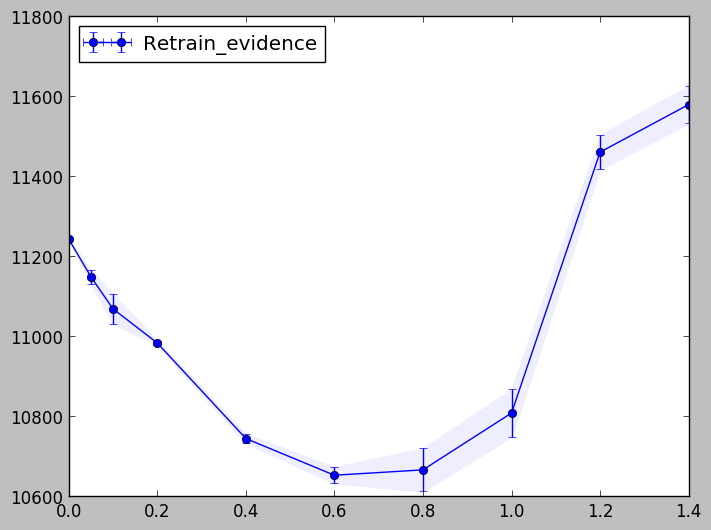

In [174]:
fig, ax = plt.subplots()
# line_1, = ax.plot(result_df_all.mean(axis=0).loc[:,'Lambda'].values,result_df_all.mean(axis=0).loc[:,'Retrain_evidence'].values, marker='o')
x = result_df_all.mean(axis=0).loc[:,'Lambda'].values
y = result_df_all.mean(axis=0).loc[:,'Retrain_evidence'].values
xerr = result_df_all.std(axis=0).loc[:,'Lambda'].values
yerr = result_df_all.std(axis=0).loc[:,'Retrain_evidence'].values

line_1 = ax.errorbar(x=x,y=y,xerr=xerr,yerr=yerr,marker='o')
ax.legend(['Retrain_evidence'],loc='upper left')
ax.fill_between(x, y-yerr, y+yerr,color='#eeeeff')
plt.savefig('Pictures/evidence_lambda_'+suffix)

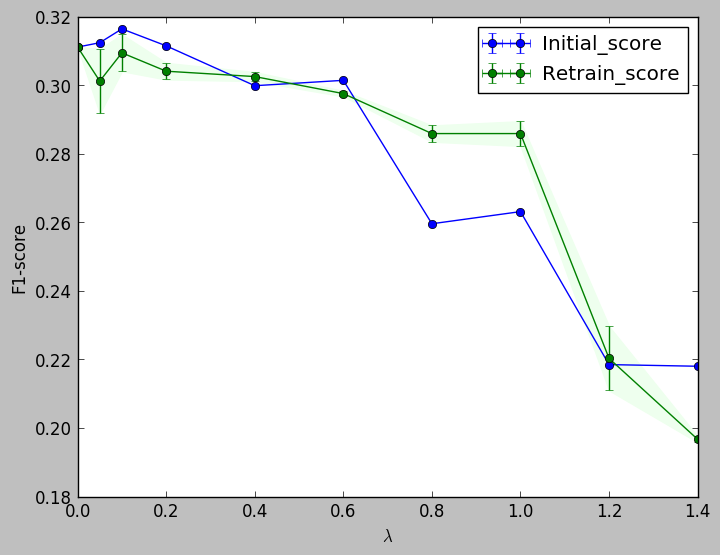

In [196]:
fig, ax = plt.subplots()
x = result_df_all.mean(axis=0).loc[:,'Lambda'].values
y_1 = result_df_all.mean(axis=0).loc[:,'Initial_score'].values
y_2 = result_df_all.mean(axis=0).loc[:,'Retrain_score'].values
x_err = result_df_all.std(axis=0).loc[:,'Lambda'].values
y_1_err = result_df_all.std(axis=0).loc[:,'Initial_score'].values
y_2_err = result_df_all.std(axis=0).loc[:,'Retrain_score'].values

line_1 = ax.errorbar(x=x,y=y_1,xerr=x_err,yerr=y_1_err, marker='o')
line_2 = ax.errorbar(x=x,y=y_2,xerr=x_err,yerr=y_2_err, marker='o')
ax.legend(['Initial_score','Retrain_score'])

ax.fill_between(x, y_2-y_2_err, y_2+y_2_err,color='#eeffee')

plt.xlabel('$\lambda$')
plt.ylabel('F1-score')

plt.savefig('Pictures/lambda_'+suffix)

score(доля оставшихся весов)

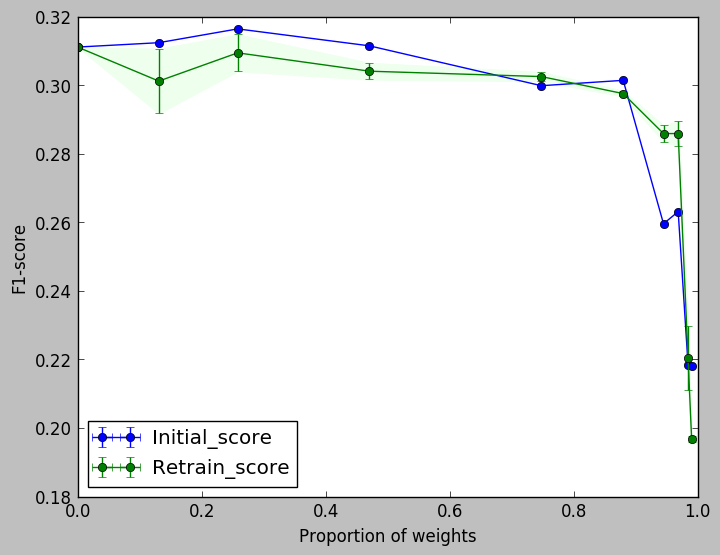

In [197]:
fig, ax = plt.subplots()

x = 1-result_df_all.mean(axis=0).loc[:,'Portion_of_weights'].values
y_1 = result_df_all.mean(axis=0).loc[:,'Initial_score'].values
y_2 = result_df_all.mean(axis=0).loc[:,'Retrain_score'].values
x_err = result_df_all.std(axis=0).loc[:,'Portion_of_weights'].values
y_1_err = result_df_all.std(axis=0).loc[:,'Initial_score'].values
y_2_err = result_df_all.std(axis=0).loc[:,'Retrain_score'].values

line_1 = ax.errorbar(x=x,y=y_1,xerr=x_err,yerr=y_1_err, marker='o')
line_2 = ax.errorbar(x=x,y=y_2,xerr=x_err,yerr=y_2_err, marker='o')

ax.legend(['Initial_score','Retrain_score'],loc='lower left')

ax.fill_between(x, y_2-y_2_err, y_2+y_2_err,color='#eeffee')

plt.xlabel('Proportion of weights')
plt.ylabel('F1-score')

plt.savefig('Pictures/portion_'+suffix)

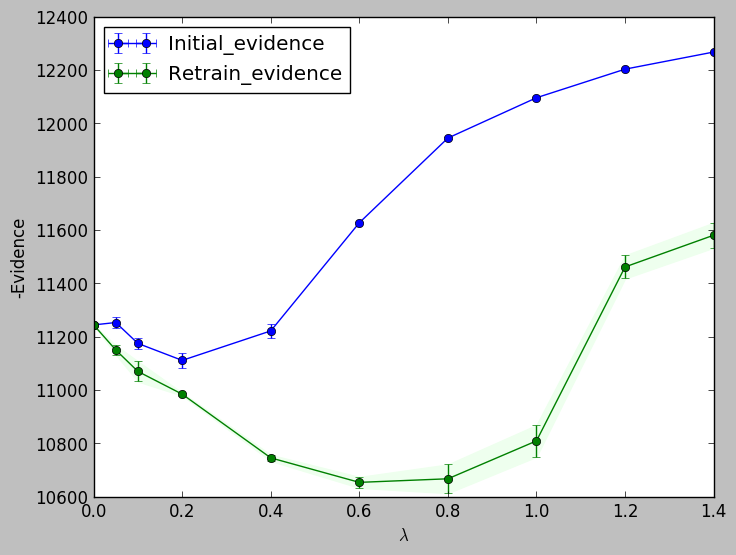

In [198]:
fig, ax = plt.subplots()

x = result_df_all.mean(axis=0).loc[:,'Lambda'].values
y_1 = result_df_all.mean(axis=0).loc[:,'Initial_evidence'].values
y_2 = result_df_all.mean(axis=0).loc[:,'Retrain_evidence'].values
x_err = result_df_all.std(axis=0).loc[:,'Lambda'].values
y_1_err = result_df_all.std(axis=0).loc[:,'Initial_evidence'].values
y_2_err = result_df_all.std(axis=0).loc[:,'Retrain_evidence'].values

line_1 = ax.errorbar(x=x,y=y_1,xerr=x_err,yerr=y_1_err, marker='o')
line_2 = ax.errorbar(x=x,y=y_2,xerr=x_err,yerr=y_2_err, marker='o')

ax.legend(['Initial_evidence','Retrain_evidence'],loc='upper left')
ax.fill_between(x, y_2-y_2_err, y_2+y_2_err,color='#eeffee')

plt.xlabel('$\lambda$')
plt.ylabel('-Evidence')

plt.savefig('Pictures/pruning_evidence_'+suffix)